# SketchGAN prototype

In [1]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os, os.path
from PIL import Image
from collections import deque

In [2]:
#global vars
std_patch_size=46
std_output_channel=64
gpu_enabled=torch.cuda.is_available()
fake_prob=0.5
d_step=40
g_step=8
edge_threshold=0.2
std_sketch_loss=nn.L1Loss()
g_learning_rate=1e-3
d_learning_rate=1e-3
max_num_fake=10
optim_betas = (0.9, 0.999)
dtype=torch.cuda.FloatTensor if gpu_enabled else torch.FloatTensor

In [3]:
#preprocessing functions
def LoadDataSet(path)->"grayscale pictures":
    res=[]
    for f in os.listdir(path):
        img=Image.open(os.path.join(path,f))
        w,h=img.size
        w=std_patch_size*round(w/std_patch_size)
        h=std_patch_size*round(h/std_patch_size)
        transform=T.Compose([T.Resize((h,w)),T.Grayscale(1),T.ToTensor()])
        res.append(transform(img).type(dtype))#scale between -1 and 1
    return res

def Tensor2Patch(img,patch_size=std_patch_size):
    assert(img.shape[0]==1 and img.shape[1]%std_patch_size==0 and img.shape[2]%std_patch_size==0)
    res,size=[],(int(img.shape[1]/std_patch_size),int(img.shape[2]/std_patch_size))
    for i in range(size[0]):
        for j in range(size[1]):
            res.append(img[:,i*std_patch_size:(i+1)*std_patch_size,j*std_patch_size:(j+1)*std_patch_size])
    return torch.stack(res),size

def Patch2Tensor(patches,size):
    return torch.cat(tuple(torch.cat(tuple(patches[i*size[1]+j] for j in range(size[1])),2) for i in range(size[0])),1)
        


In [4]:
#util functions/classes
def Tensor2Image(tensor):
    return tensor.numpy().squeeze() # denormalize

def ShowImage(img):
    plt.imshow(img,cmap='gray')
    plt.show()

def Tensor2Edges(img,mode='Sobel')->"edges":
    #cv2.Laplacian
    #cv2.Sobel
    #cv2.Canny
    img=img.squeeze()
    res=np.uint8(img*255)
    if mode=='Canny':
        res=cv2.Canny(res,80,150)/255
    elif mode=='Laplacian':
        res=cv2.Laplacian(res,cv2.CV_8U)/255
    elif mode=='Sobel':
        res=cv2.Sobel(res,cv2.CV_8U,1,1,ksize=5)/255
    else:
        return None
    return torch.tensor(1-res).unsqueeze(0).type(dtype)

def StketchLoss(img,edges)->"loss":
    assert(img.shape==edges.shape)
    threshold=torch.Tensor.float(edges>edge_threshold).type(dtype)
    return std_sketch_loss(img*threshold,edges*threshold).type(dtype) #L1 loss

def ProbLessthan(prob):
    return random.random()<prob

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)
    
    

In [5]:
#Generator (patched) size=30x30
class UNet_Down(nn.Module):
    def __init__(self,in_c,out_c,ksize=3):
        super(UNet_Down, self).__init__()
        #size=(size-4)
        self.net=nn.Sequential(
            nn.Conv2d(in_c,out_c,ksize),
            nn.BatchNorm2d(out_c),
            nn.ELU(inplace=True),
            nn.Conv2d(out_c,out_c,ksize),
            nn.BatchNorm2d(out_c),
            nn.ELU(inplace=True),
            nn.AvgPool2d(2))
    def forward(self,x):
        return self.net(x)
    
class UNet_Up(nn.Module):
    def __init__(self,in_c,out_c,ksize=3):
        super(UNet_Up, self).__init__()
        self.net=nn.Sequential(
            nn.PixelShuffle(2),
            nn.ConvTranspose2d(int(in_c/4),out_c,ksize),
            nn.BatchNorm2d(out_c),
            nn.ELU(inplace=True),
            nn.ConvTranspose2d(out_c,out_c,ksize),
            nn.BatchNorm2d(out_c),
            nn.ELU(inplace=True))
    def forward(self,in_x,to_crop):
        p=in_x.shape[2]-to_crop.shape[2]
        p_up=round(p/2)
        p_down=p-p_up
        to_crop=F.pad(to_crop,(p_up,p_down,p_up,p_down))
        #print('in_x.shape:',in_x.shape,'to_crop.shape',to_crop.shape)
        x=torch.cat([in_x,to_crop],dim=1)
        #print('x.shape:',x.shape)
        return self.net(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # NCHW format: N x 1 x patch_size x patch_size (grayscale) 30x30
        self.start=nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.BatchNorm2d(32),
            nn.ELU(inplace=True))#26
        self.down1=UNet_Down(32,64)# 18
        self.down2=UNet_Down(64,128)# 10
        self.down3=UNet_Down(128,256)# 2
        self.deepest=nn.Sequential(
            nn.Conv2d(256,512,2),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            nn.ConvTranspose2d(512,256,2),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
        )
        self.up3=UNet_Up(512,128)# 10
        self.up2=UNet_Up(256,64)# 18
        self.up1=UNet_Up(128,32)# 26
        self.end=nn.Sequential(nn.ConvTranspose2d(32,1,3))
    def forward(self,x):
        x=self.start(x)
        down1_y=self.down1(x)
        #print('down1.shape:',down1_y.shape)
        down2_y=self.down2(down1_y)
        #print('down2.shape:',down2_y.shape)
        down3_y=self.down3(down2_y)
        #print('down3.shape:',down3_y.shape)
        deepest_y=self.deepest(down3_y)
        #print('deepest_y.shape:',deepest_y.shape)
        x=self.up3(deepest_y,down3_y)
        x=self.up2(x,down2_y)
        x=self.up1(x,down1_y)
        return self.end(x)
        
    

In [6]:
#Discriminator (patched) size=64x64
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        # NCHW format: N x 1 x patch_size x patch_size (grayscale) 64x64
        self.net=nn.Sequential(
        nn.Conv2d(1,32,7),#44
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        nn.Dropout(0.1),
        Flatten(),
        nn.Linear(40*40*32,512),
        nn.Dropout(),
        nn.BatchNorm1d(512),
        nn.ReLU(True),
        nn.Linear(512,512),
        nn.Dropout(),
        nn.BatchNorm1d(512),
        nn.ReLU(True),
        nn.Linear(512,1),
        nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [7]:
#training process
G=Generator().type(dtype)
D=Discriminator().type(dtype)
G_opt=optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)
D_opt=optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
G_loss=StketchLoss
D_loss=nn.BCELoss().type(dtype)
GenSet,GroundTruth,Fake=LoadDataSet('NOT_Sketch_Set/'),LoadDataSet('Sketch_Set/'),deque([],max_num_fake)

def GetOutput(model,patches)->"model output":
    output=model(patches)
    if type(model)==Discriminator:
        return output.mean()
    else:
        return output

def TrainDiscriminator(img,label):
    D_opt.zero_grad()
    patches,size=Tensor2Patch(img)
    D_res=GetOutput(D,patches)
    D_err=D_loss(D_res,label)
    res=D_err.item()
    D_err.backward()
    D_opt.step()
    return res
    
def TrainGenerator(img):
    G_opt.zero_grad()
    patches,size=Tensor2Patch(img)
    G_res=GetOutput(G,patches)
    D_res=GetOutput(D,G_res)
    G_tensor=Patch2Tensor(G_res,size)
    G_err=G_loss(G_tensor,Tensor2Edges(img))+D_loss(D_res,torch.ones(1).type(dtype))
    res=G_err.item()
    G_err.backward()
    G_opt.step()
    return res
    
def TrainStep(D_loss_hist=None,G_loss_hist=None):
    D.train()
    D_loss,G_loss=None,None
    for p in D.parameters():
        p.requires_grad=True
    for _ in range(d_step):
        if len(Fake)==0 or ProbLessthan(fake_prob):
            D_loss=TrainDiscriminator(random.choice(GroundTruth),torch.ones(1).type(dtype))
        else:
            D_loss=TrainDiscriminator(random.choice(Fake),torch.zeros(1).type(dtype))
    if D_loss_hist!=None and D_loss!=None:
        D_loss_hist.append(D_loss)
    D.eval()
    G.train()
    for p in D.parameters():
        p.requires_grad=False
    for _ in range(g_step):
        G_loss=TrainGenerator(random.choice(GenSet))
    if G_loss_hist!=None and G_loss!=None:
        G_loss_hist.append(G_loss)
        

def Check_D(model):
    model.eval()
    correct=0
    for i in GroundTruth:
        with torch.no_grad():
            patches,size=Tensor2Patch(i)
            D_res=GetOutput(model,patches)
            if D_res>=0.5:
                correct+=1
    for i in Fake:
        with torch.no_grad():
            patches,size=Tensor2Patch(i)
            D_res=GetOutput(model,patches)
            if D_res<0.5:
                correct+=1
    return correct/(len(GroundTruth)+len(Fake))
            
        
        
        
def Train(num_epochs=10,show_image=True,show_G_loss=True,show_D_loss=True,test_D=True):
    D_loss_hist,G_loss_hist=([] if show_D_loss else None),([] if show_G_loss else None)
    for _ in range(num_epochs):
        TrainStep(D_loss_hist,G_loss_hist)
        G.eval()
        with torch.no_grad():
            test_sample=random.choice(GenSet)
            patches,size=Tensor2Patch(test_sample)
            G_res=GetOutput(G,patches)
            G_tensor=Patch2Tensor(G_res,size).detach()
            Fake.append(G_tensor)
            Edges=Tensor2Edges(test_sample)
            if show_image:
                ShowImage(Tensor2Image(G_tensor.cpu()))
                ShowImage(Tensor2Image(Edges.cpu()))
                print("loss:",G_loss(G_tensor,Edges).item())
    if show_G_loss:
        plt.plot(range(1,num_epochs+1),G_loss_hist)
        plt.title("Generator Loss")
        plt.show()
    if show_D_loss:
        plt.plot(range(1,num_epochs+1),D_loss_hist)
        plt.title("Discriminator Loss")
        plt.show()
    if test_D:
        print("Discriminator's Accuracy:",Check_D(D))
        
        

F:\Anaconda\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


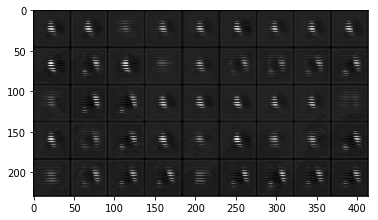

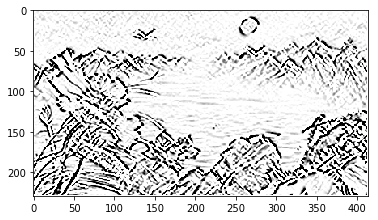

loss: 0.18757344782352448


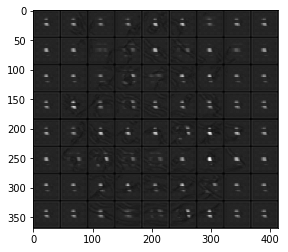

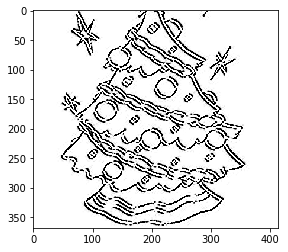

loss: 0.11549107730388641


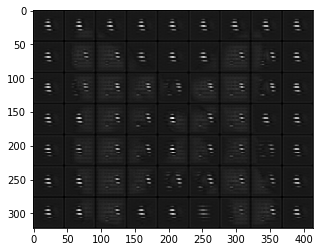

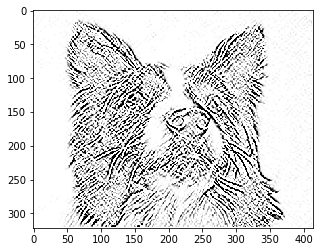

loss: 0.2349359393119812


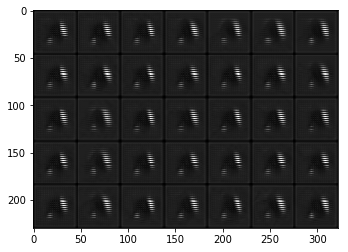

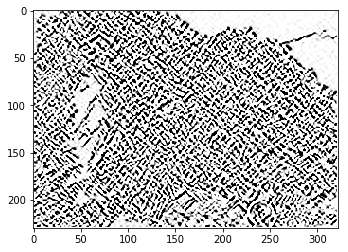

loss: 0.18624627590179443


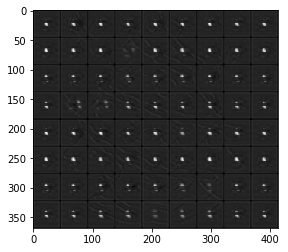

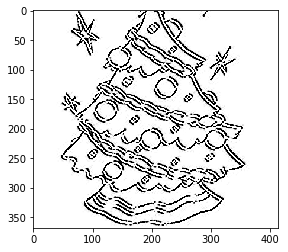

loss: 0.11441876739263535


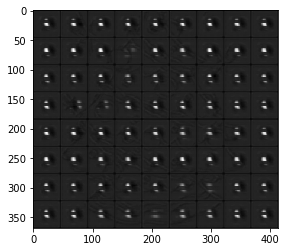

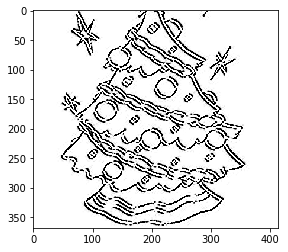

loss: 0.1613493710756302


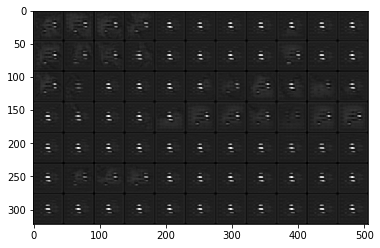

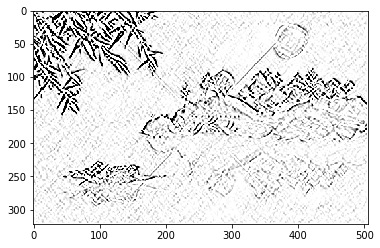

loss: 0.16095438599586487


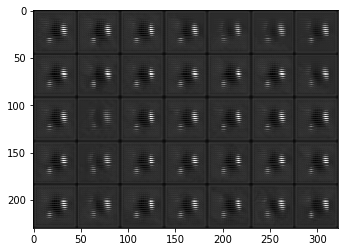

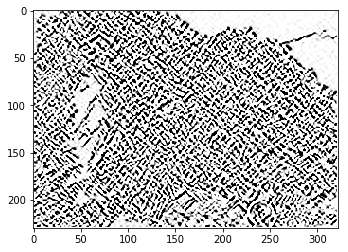

loss: 0.1730903685092926


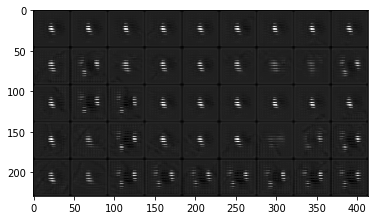

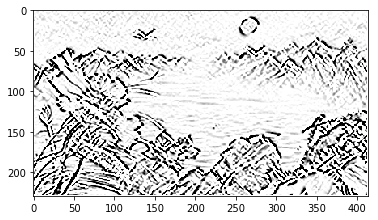

loss: 0.15686722099781036


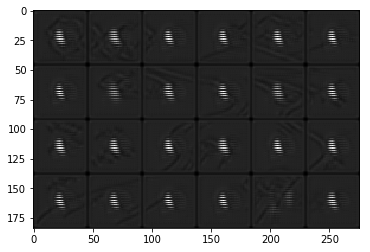

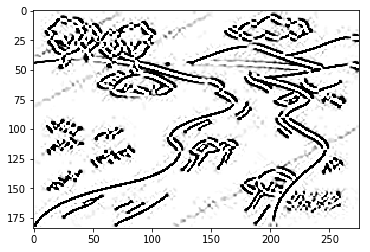

loss: 0.10014690458774567


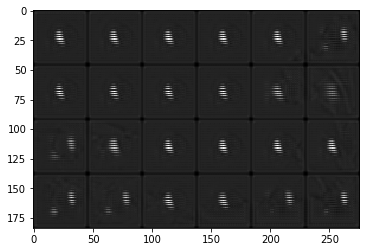

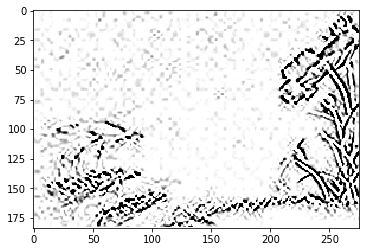

loss: 0.11120869219303131


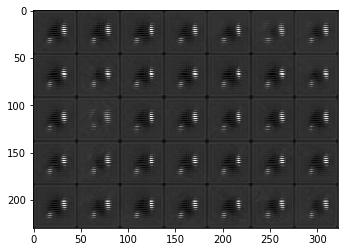

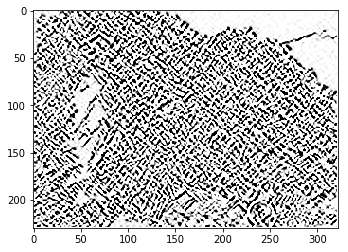

loss: 0.1525435447692871


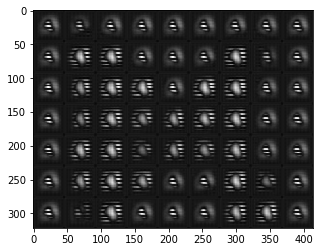

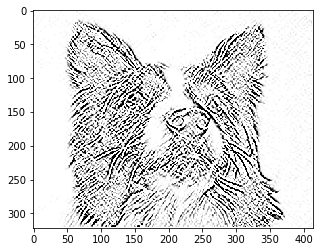

loss: 0.5090970993041992


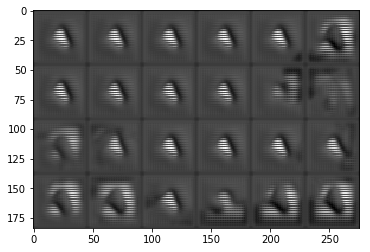

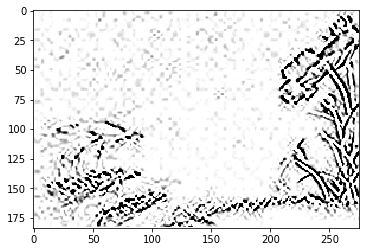

loss: 0.3351615369319916


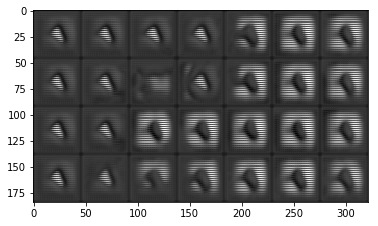

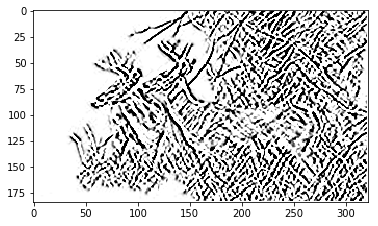

loss: 0.37217602133750916


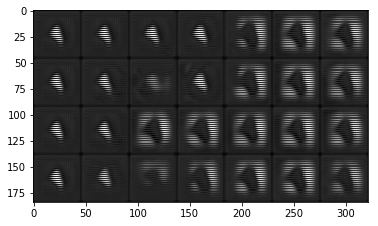

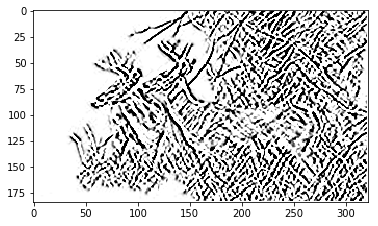

loss: 0.27740898728370667


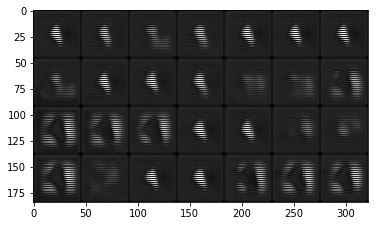

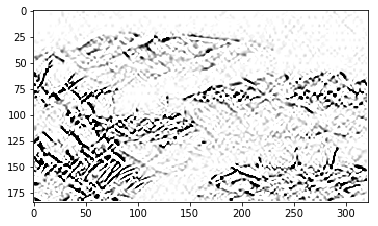

loss: 0.21205447614192963


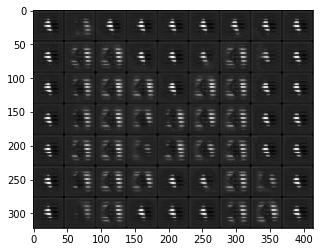

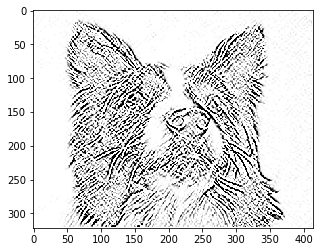

loss: 0.22745583951473236


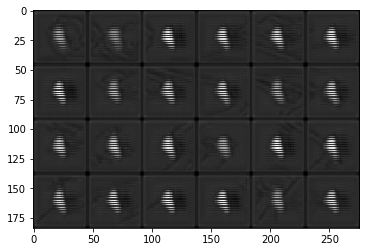

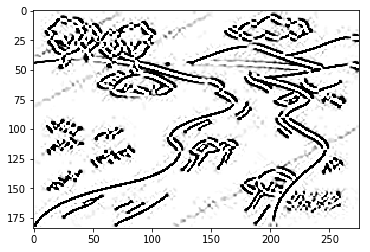

loss: 0.1346946805715561


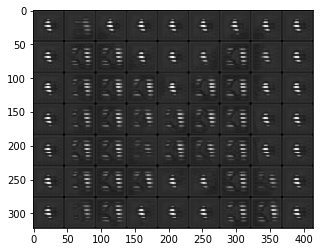

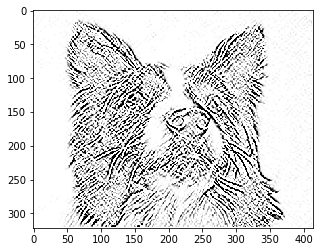

loss: 0.16408219933509827


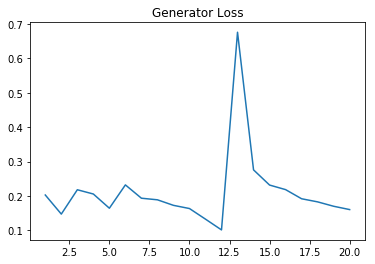

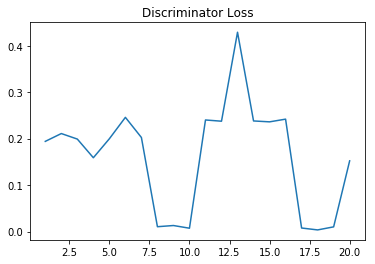

Discriminator's Accuracy: 0.3


In [9]:
Train(20)

In [9]:

for i in range(10):
    D.train()
    for j in GroundTruth:
        k=TrainDiscriminator(j,torch.ones(1).type(dtype))
    for j in GenSet:
        k=TrainDiscriminator(j,torch.zeros(1).type(dtype))
    print("Discriminator's Accuracy:",Check_D(D))

F:\Anaconda\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Discriminator's Accuracy: 0.6
Discriminator's Accuracy: 0.05
Discriminator's Accuracy: 0.5
Discriminator's Accuracy: 0.6
Discriminator's Accuracy: 0.7
Discriminator's Accuracy: 0.8
Discriminator's Accuracy: 0.6
Discriminator's Accuracy: 0.65
Discriminator's Accuracy: 0.35
Discriminator's Accuracy: 0.6
